In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from copy import deepcopy

PALETTE_PARAMS='Accent'

PALETTE='Set2'

ST3="data3/PAT_ph_best_compare_results.tsv"


def line_break(s, split=', ', k=3):
    items = s.split(split)
    grouped_items = [split.join(items[i:i+k]) for i in range(0, len(items), k)]
    return ',\n'.join(grouped_items)

In [14]:
ct_name="Total" #'Знач. наб. SNP' # clumps total
cc_name="Precision" #'СС (Доля наборов, содержащих причинные SNP)'
sf_name="Recall" #'SF (Доля найденных причинных SNP)'

column_names = {"m_beta":"effect size (m_beta)", 
                "sd_beta":"standard deviation of effect size (sd_beta)", 
                "gen_var":"genetic effects variance (gen_var)", 
                "h2s":"proportion of the genetic variant effect variance (h2s)", # should be 1, we don't have background noise in genetic components
                "theta":"proportion of variance\nof shared genetic variant effects (theta)",
                "pIndep":"proportion of genetic variant effects\nto have a trait-independent fixed effect (pIndependent)",
                "phi":"proportion of observational noise effect variance (phi)",
                "alpha":"variance of shared observational noise effect (alpha)",
               "K": 'amount of causal SNPs (K); k=K/2'}


In [17]:
list(column_names.keys())

['m_beta', 'sd_beta', 'gen_var', 'h2s', 'theta', 'pIndep', 'phi', 'alpha', 'K']

In [15]:
data = pd.read_csv(ST3, sep='\t')
data['params'] = '('+data.m_beta.astype(str) + ", " + data.sd_beta.astype(str) + ", " + data.gen_var.astype(str) + ", " + data.h2s.astype(str) + ")"
data.K = data.K.astype(int)
data = data.rename(columns={'clumps_causal':cc_name, "causal_found": sf_name, 'clumps_total': ct_name})
data['F1'] = 2/(1/data.Precision+1/data.Recall)
print(data.shape)
data.head()

(400, 17)


,K,m_beta,sd_beta,gen_var,h2s,theta,pIndep,phi,alpha,Total,Precision,Recall,F1,seed,clumps_not_causal,causal_not_found,params
0,10,0.05,0.001,0.1,1.0,0.0,1.0,1.0,0.0,7,0.14286,0.1,0.117648,2335020,0.85714,0.9,"(0.05, 0.001, 0.1, 1.0)"
1,10,0.05,0.001,0.1,1.0,0.0,1.0,1.0,0.0,9,0.11111,0.1,0.105263,2643371,0.88889,0.9,"(0.05, 0.001, 0.1, 1.0)"
2,10,0.05,0.001,0.1,1.0,0.0,1.0,1.0,0.0,7,0.14286,0.1,0.117648,2631448,0.85714,0.9,"(0.05, 0.001, 0.1, 1.0)"
3,10,0.05,0.001,0.1,1.0,0.0,1.0,1.0,0.0,8,0.12500,0.1,0.111111,7314238,0.87500,0.9,"(0.05, 0.001, 0.1, 1.0)"
4,10,0.05,0.001,0.1,1.0,0.0,1.0,1.0,0.0,8,0.12500,0.1,0.111111,1994957,0.87500,0.9,"(0.05, 0.001, 0.1, 1.0)"


In [25]:
data[['m_beta', 'sd_beta', 'gen_var', 'h2s', 'theta', 'pIndep', 'phi', 'alpha',]].drop_duplicates()

,m_beta,sd_beta,gen_var,h2s
0,0.05,0.001,0.1,1.0
40,0.05,0.001,0.5,1.0
160,0.05,0.010,0.5,1.0
220,0.50,0.050,0.1,1.0
280,0.50,0.050,0.5,1.0


## Clumps causal - causal found

Let: Clumps causal = CC, Causal found = SF

In [6]:
d = data
# d = d[d.clumps_total != 0]

darr = d.copy(deep=True)[((d.Recall>0.99) & (d.Precision>0.99))]
darr.sort_values(by=['Precision', 'Recall'], ascending=[False, False], inplace=True)

darr['x']=0
darr['y']=0
darr.shape

(22, 19)

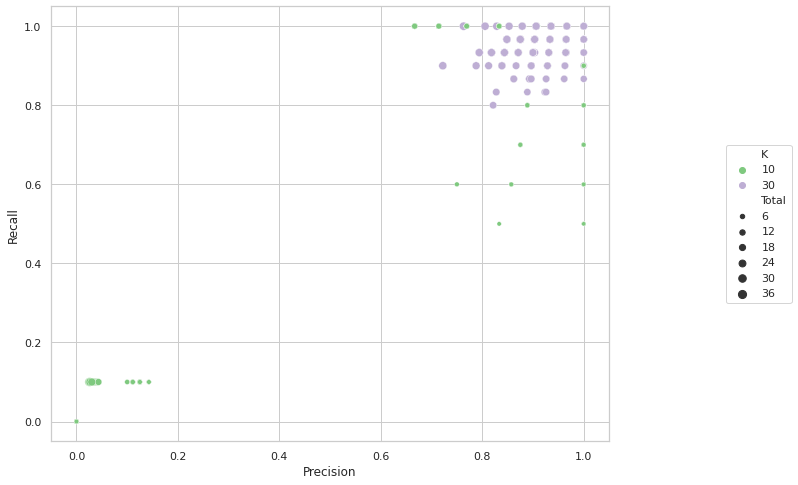

In [7]:
sns.set()
plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid")
ax = sns.scatterplot(d, 
                     x='Precision', 
                     y='Recall', 
                     hue='K', 
                     size=ct_name, 
                     palette=PALETTE_PARAMS,  
                     alpha=1,)

plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.savefig('images/SF4.2.pdf')
plt.show()

## Params -- CC/SF

In [8]:
def draw_violins(d, cur_y, cur_name, columns, min_y=-0.05, max_y=1.05):
    sns.set(rc={"figure.figsize": (15, 10)})
    sns.set_theme(style="whitegrid")
    # get legend
    ax = sns.violinplot(d, 
                        x=columns[0], #!!!!!!!!!!!!!!!!!!!!! эт че
                        y=cur_y, 
                        hue='K', palette=PALETTE_PARAMS)
    handles, labels = ax.get_legend_handles_labels()
    plt.clf()
    # draw
    fig, axs = plt.subplots(nrows=2, ncols=2)
    for i, c in enumerate(columns):
        row = i // 2
        col = i % 2
        ax = sns.stripplot(d, 
                            x=c, 
                            y=cur_y, 
                            hue='K', 
                            palette=PALETTE_PARAMS,
                            alpha=.7,
                            ax=axs[row][col], 
                            legend=False, 
                           dodge=True
                           )
        
        ax = sns.violinplot(d, 
                            x=c, 
                            y=cur_y, 
                            hue='K', 
                            palette=PALETTE_PARAMS,
                            alpha=.7,
                            ax=axs[row][col], 
                            legend=False, 
                            cut=1
                           )
        plt.setp(ax.collections, alpha=.58)
        ax.legend_.remove()
        ax.set(ylabel='', xlabel=column_names[c])
        ax.set(ylim=(min_y, max_y))
        ax
    fig.supylabel(cur_name, y=0.5, x=0.07)
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.9, 0.5), title=column_names['K'])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    plt.show()

In [9]:
columnses = [["m_beta", "sd_beta", "gen_var", "h2s"], 
            ["theta","pIndep","phi","alpha"]]

<Figure size 1080x720 with 0 Axes>

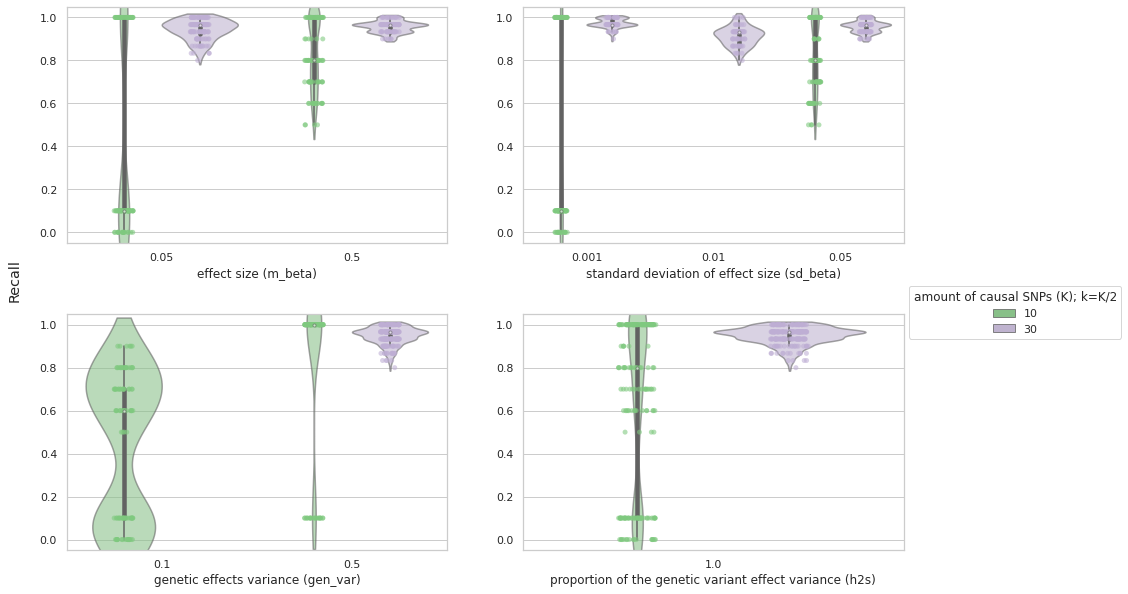

<Figure size 1080x720 with 0 Axes>

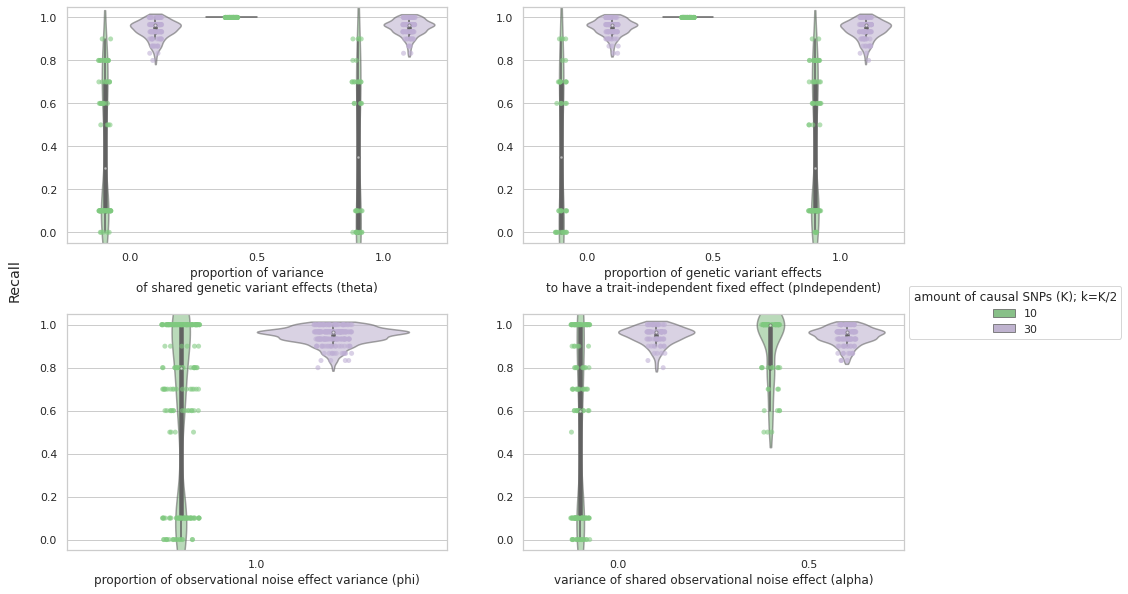

<Figure size 1080x720 with 0 Axes>

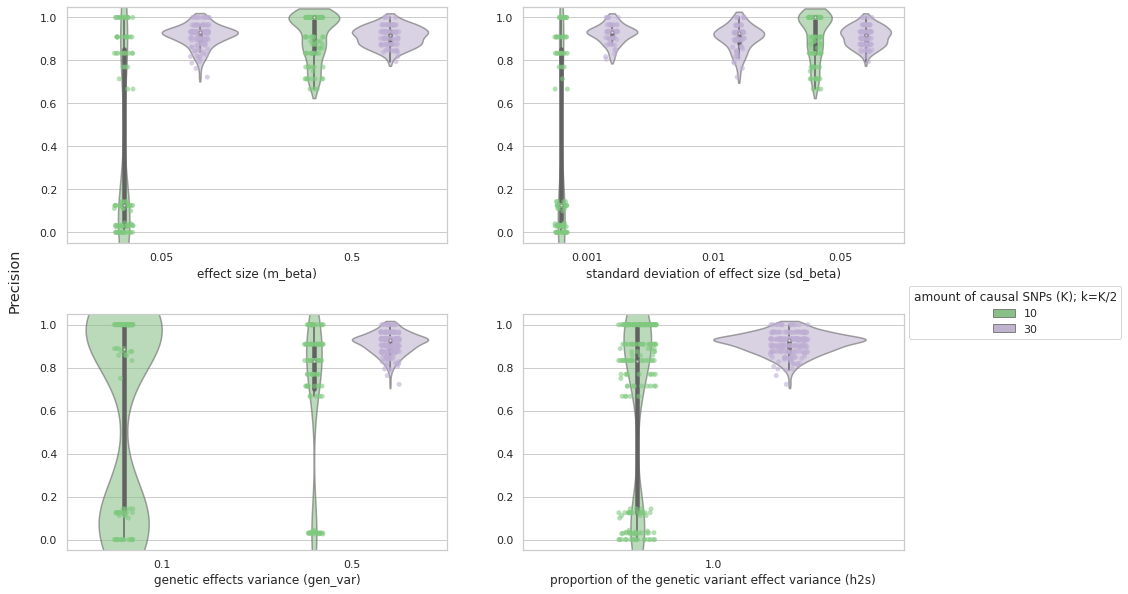

<Figure size 1080x720 with 0 Axes>

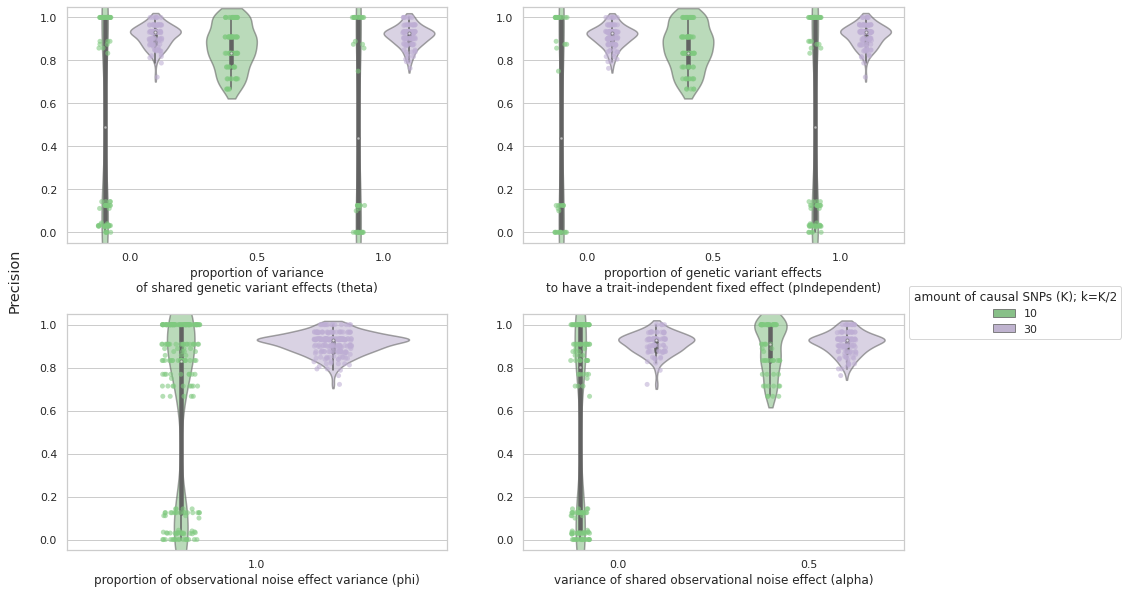

<Figure size 1080x720 with 0 Axes>

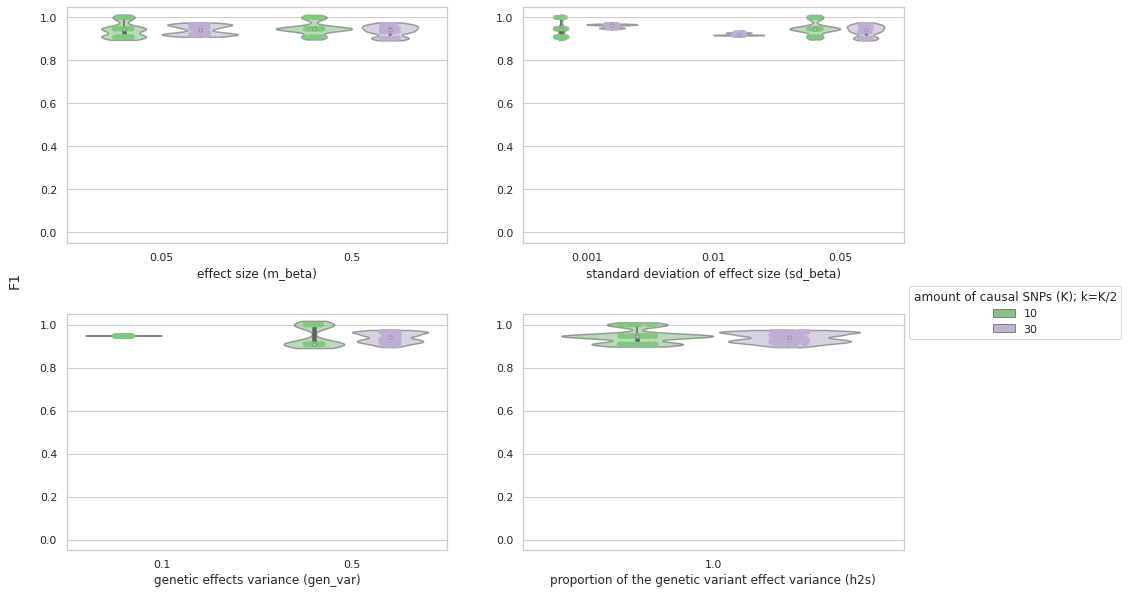

<Figure size 1080x720 with 0 Axes>

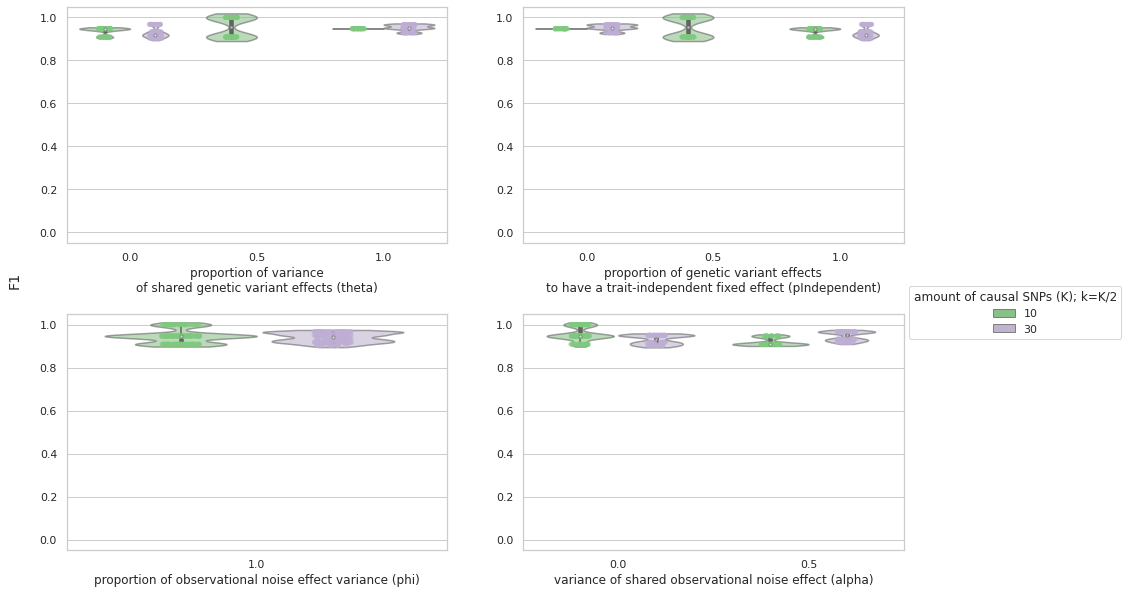

In [10]:
cur_ys = ['Recall', 'Precision', 'F1']
cur_names = [sf_name, cc_name, 'F1']

for cur_y, cur_name in zip(cur_ys, cur_names):
    for columns in columnses:
        draw_violins(d, cur_y, cur_name, columns)

## Distribution per param.set

And selection the best

In [119]:
Xs_cols = ['K', 'm_beta', 'sd_beta', 'gen_var', 'h2s', 'theta', 'pIndep', 'phi', 'alpha']

In [121]:
data['F1'] = 2/(1/data.Precision+1/data.Recall)
data_best = data.copy(deep=True).groupby(Xs_cols).agg({'F1':'mean'})

data_best = data_best[data_best.F1>0.95]
# print(data_best.shape)
# data_best.head()
data_best

,,,,,,,,,F1
K,m_beta,sd_beta,gen_var,h2s,theta,pIndep,phi,alpha,
10,0.05,0.001,0.5,1.0,0.5,0.5,1.0,0.5,0.951443
30,0.05,0.001,0.5,1.0,0.0,1.0,1.0,0.5,0.951066


FrozenList(['K', 'm_beta', 'sd_beta', 'gen_var', 'h2s', 'theta', 'pIndep', 'phi', 'alpha'])

In [133]:
best_groups = list(data_best.index)
item_names = list(data_best.index.names)

In [123]:
grouped = data.groupby(Xs_cols)
array_of_data = {traits: group for traits, group in grouped}

--------------------
{'K': 10, 'm_beta': 0.05, 'sd_beta': 0.001, 'gen_var': 0.5, 'h2s': 1.0, 'theta': 0.5, 'pIndep': 0.5, 'phi': 1.0, 'alpha': 0.5}


,mean,std
trait,,
F1,0.951443,0.058030
Precision,0.912703,0.101346
Recall,1.000000,0.000000


/tmp/ipykernel_4425/2571648949.py:33: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(data=cur_data_m,


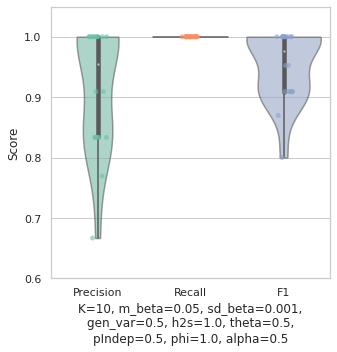

--------------------
--------------------
{'K': 30, 'm_beta': 0.05, 'sd_beta': 0.001, 'gen_var': 0.5, 'h2s': 1.0, 'theta': 0.0, 'pIndep': 1.0, 'phi': 1.0, 'alpha': 0.5}


,mean,std
trait,,
F1,0.951066,0.027627
Precision,0.930762,0.042123
Recall,0.973335,0.025592


/tmp/ipykernel_4425/2571648949.py:33: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(data=cur_data_m,


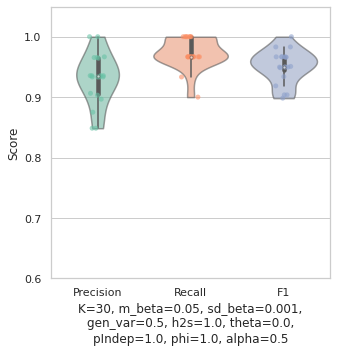

--------------------


In [164]:
sns.set(rc={"figure.figsize": (5, 5)})
sns.set_theme(style="whitegrid")

opposite_k = {10:30,30:10}

already_used = set()
i=1
for _traits in array_of_data:
    # iterate pfver sets of parameters that can be good
    traits = list(deepcopy(_traits))
    for K in [10, 30]:
        traits[0]=K
        try:
            cur_data = array_of_data[tuple(traits)]
            traits2 = deepcopy(traits)
            traits2[0]=opposite_k[K]
            if tuple(traits) not in best_groups and tuple(traits2) not in best_groups:
                continue
        except KeyError:
            continue
        print('--------------------')
        datas = []
        cols = [cc_name, sf_name, 'F1']
        for col in cols:
            cur_data['trait'] = col
            d1 = cur_data[[col, 'trait']].rename(columns={col:'score'})
            datas.append(d1)
        cur_data_m = pd.concat(datas)
        grouped = cur_data_m.groupby('trait')['score'].agg(['mean', 'std'])
        print({k: t for k, t in zip(Xs_cols, traits)})
        display(grouped)
        
        ax = sns.stripplot(data=cur_data_m, 
                       x='trait', 
                       y='score',
                       palette=PALETTE,
                           dodge=False
                           )
        
        ax = sns.violinplot(data=cur_data_m, 
                       x='trait', 
                       y='score',
                       palette=PALETTE,
                            cut=0
                           )
        plt.setp(ax.collections, alpha=.58)
        ax.set(ylim=(0.6, 1.05))
#         ax.legend_.remove()
        full_x_axis_name = ', '.join([f"{name}={value}" for name, value in zip(item_names, traits)])
        ax.set(ylabel='Score', xlabel=line_break(full_x_axis_name, k=3))
        plt.savefig(f'images/F2.{i}.pdf')
        plt.show()
        i+=1
        print('--------------------')
    print('================================================================')

In [12]:
array_of_data

NameError: name 'array_of_data' is not defined